# Q1: Tri-VAE

In [1]:
import kagglehub
import shutil

## Dataset

### downloading datasets

In [2]:
try:
    path = kagglehub.dataset_download("haonanzhou1/ixit2-slices")
    shutil.copytree(path, './data/ixi')
except:
    print("folder already exists!")
shutil.rmtree(path)

100%|██████████| 781M/781M [00:09<00:00, 90.0MB/s]

Extracting files...


In [3]:
try:
    path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
except:
    print("folder already exists!")

100%|██████████| 4.16G/4.16G [01:01<00:00, 73.1MB/s]

Extracting files...


folder already exists!


In [6]:
!ls $path

BraTS2020_TrainingData	BraTS2020_ValidationData


In [7]:
import os
shutil.copytree(os.path.join(path,"BraTS2020_TrainingData"), './data/brats_training/')
shutil.rmtree(path)

'./data/brats_training/'

### showing a few instances

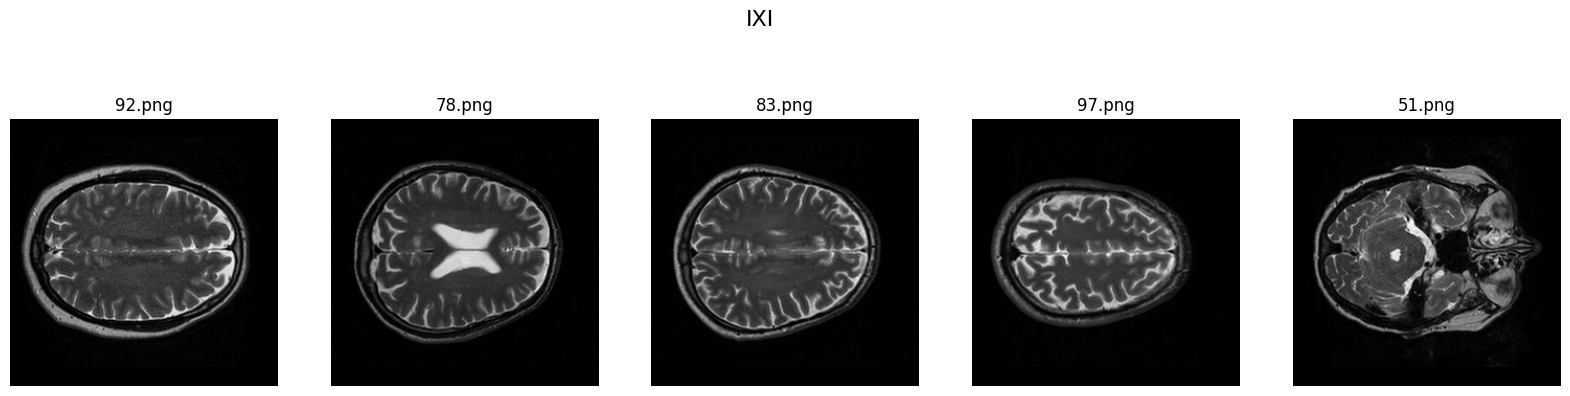

In [65]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = random.sample(os.listdir(dataset_path), 5)

fig, axes = plt.subplots(1, len(image_files), figsize=(20, 5))
fig.suptitle('IXI', fontsize=16)

for i, image_folder in enumerate(image_folders):
  image_name = random.sample(os.listdir(os.path.join(dataset_path, image_folder)), 1)[0]
  image_path = os.path.join(dataset_path, image_folder, image_name)
  image = Image.open(image_path)
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(image_name)
  axes[i].axis('off')

plt.show()

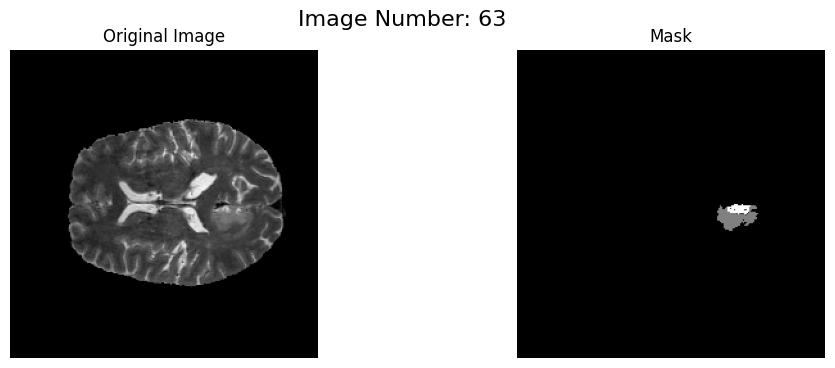

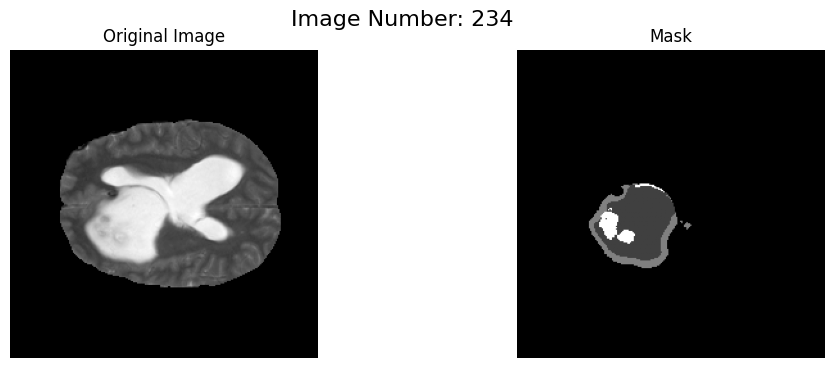

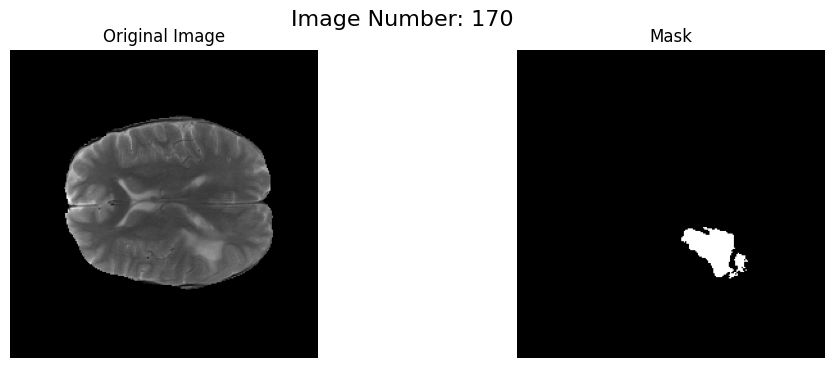

In [67]:
import matplotlib.pyplot as plt
import nibabel as nib
import random

def show_brats_data(image_addr, image_num):
  image = nib.load(image_addr)
  mask = nib.load(image_addr.replace('_t2', '_seg'))

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  fig.suptitle(f'Image Number: {image_num}', fontsize=16)

  axes[0].imshow(image.get_fdata()[:, :, image.shape[2] // 2], cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  axes[1].imshow(mask.get_fdata()[:, :, mask.shape[2] // 2], cmap='gray')
  axes[1].set_title('Mask')
  axes[1].axis('off')

  plt.show()

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
img_count=len([item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))])

for i in range(3):
  img_num=random.randint(0, img_count-1)
  img_addr=f'BraTS20_Training_{img_num:03}/BraTS20_Training_{img_num:03}_t2.nii'
  show_brats_data(os.path.join(brats_folder, img_addr), img_num)